In [41]:
import re
import spacy
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, confusion_matrix
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Fake Job Prediction using Sequential Network

In [42]:
dataset = pd.read_csv(r"fake job posting(Sheet1).csv")
dataset.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [43]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [44]:
dataset['fraudulent'].value_counts(normalize=True)

,proportion
fraudulent,
0,0.951566
1,0.048434


In [45]:
dataset.isnull().sum().sort_values(ascending=False)

,0
salary_range,15012
department,11547
required_education,8105
benefits,7212
required_experience,7050
function,6455
industry,4903
employment_type,3471
company_profile,3308
requirements,2696


In [46]:
dataset.drop(columns=['department', 'salary_range'], inplace=True)
dataset.dropna(subset=['description'], inplace=True)

fill_cols = ['company_profile', 'requirements', 'benefits', 'employment_type',
             'required_experience', 'required_education', 'industry', 'function', 'location']

dataset[fill_cols] = dataset[fill_cols].fillna("Not Provided")

In [47]:
dataset.head()

,job_id,title,location,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Provided,0,1,0,Other,Internship,Not Provided,Not Provided,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,Not Provided,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Not Provided,0,1,0,Not Provided,Not Provided,Not Provided,Not Provided,Not Provided,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [48]:
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = dataset.select_dtypes(include=['object']).columns.tolist()

# Remove target from numerical features
numerical_features.remove('fraudulent')

In [49]:
correlations = dataset[numerical_features + ['fraudulent']].corr()
correlations['fraudulent'].sort_values(ascending=False)

,fraudulent
fraudulent,1.000000
job_id,0.079510
telecommuting,0.034594
has_questions,-0.091436
has_company_logo,-0.261655


In [50]:
num_df = dataset.select_dtypes(include=['int64', 'float64'])
corr_matrix = num_df.corr()

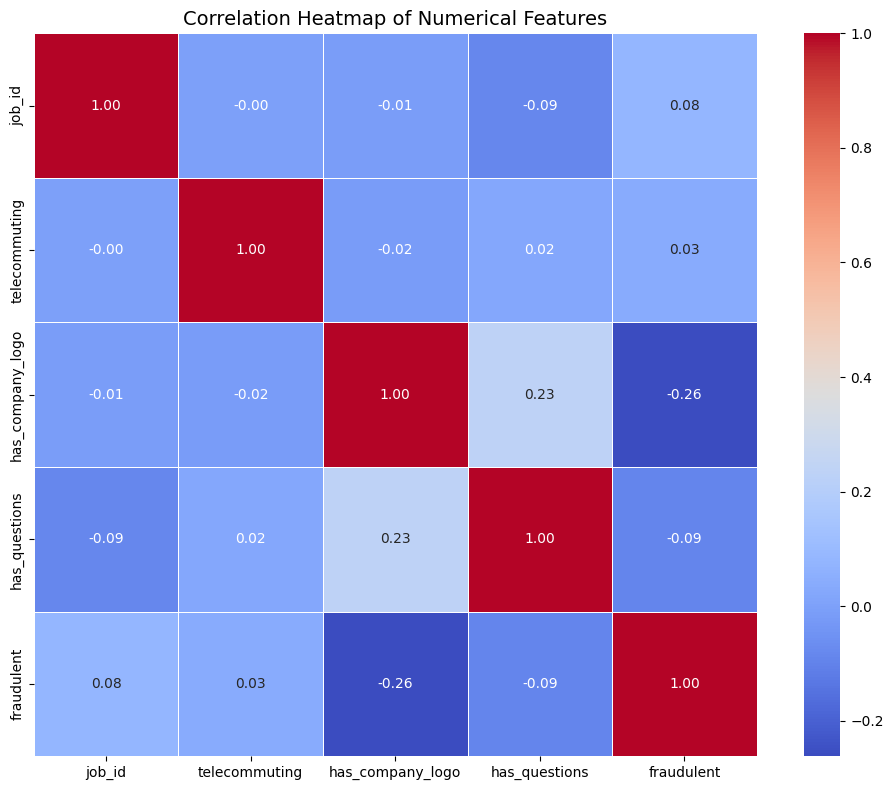

In [51]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Heatmap of Numerical Features", fontsize=14)
plt.tight_layout()
plt.show()

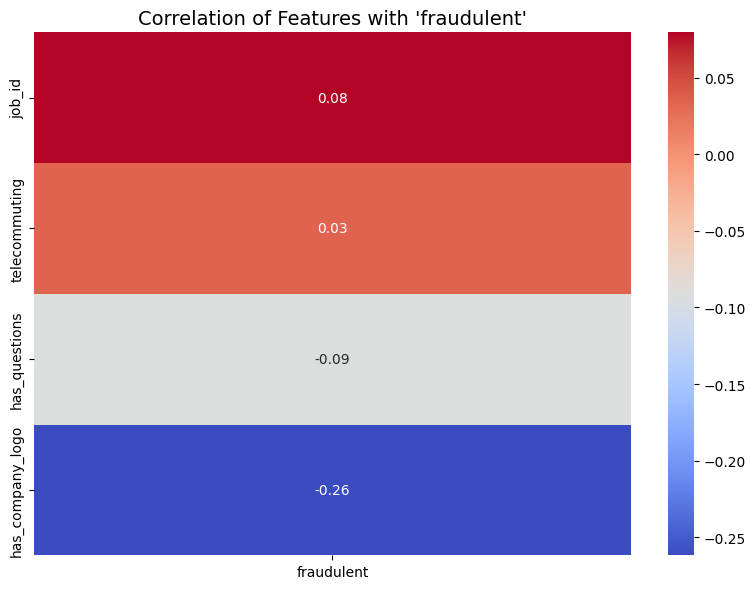

In [52]:
target_corr = corr_matrix['fraudulent'].drop('fraudulent').sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation of Features with 'fraudulent'", fontsize=14)
plt.tight_layout()
plt.show()

In [53]:
dataset.drop(columns=['job_id', 'telecommuting', 'has_questions', 'has_company_logo'], inplace=True)

In [54]:
dataset.head()

,title,location,company_profile,description,requirements,benefits,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York","We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,Not Provided,Other,Internship,Not Provided,Not Provided,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland","90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,Full-time,Not Applicable,Not Provided,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,Not Provided,Not Provided,Not Provided,Not Provided,Not Provided,Not Provided,0
3,Account Executive - Washington DC,"US, DC, Washington",Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


Text(0.5, 1.0, 'Fraudulent vs Legitimate Job Postings')

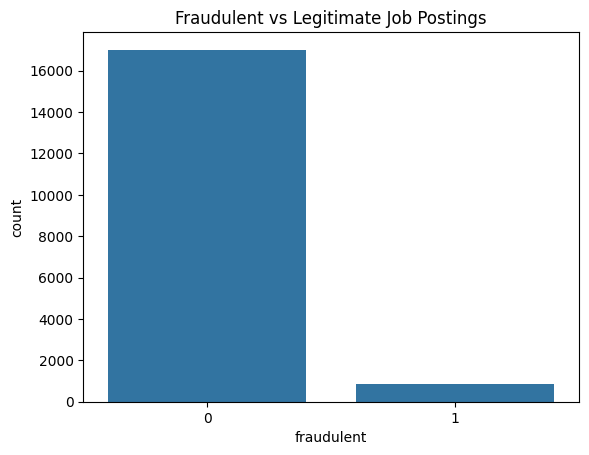

In [55]:
sns.countplot(data=dataset, x='fraudulent')
plt.title("Fraudulent vs Legitimate Job Postings")

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


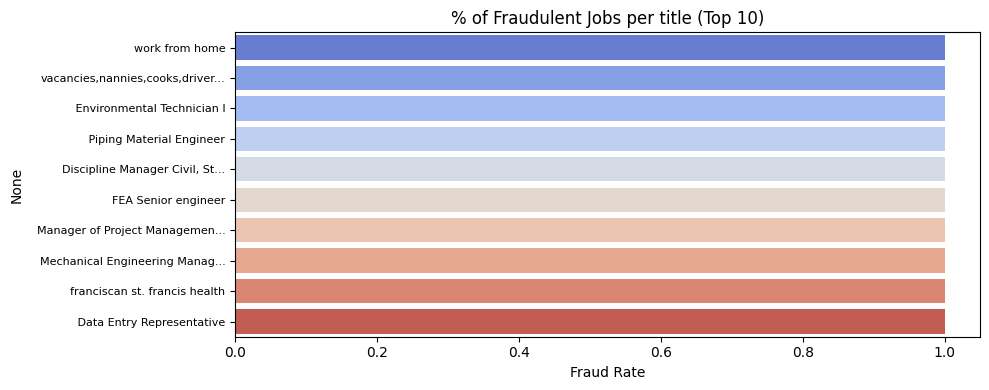

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


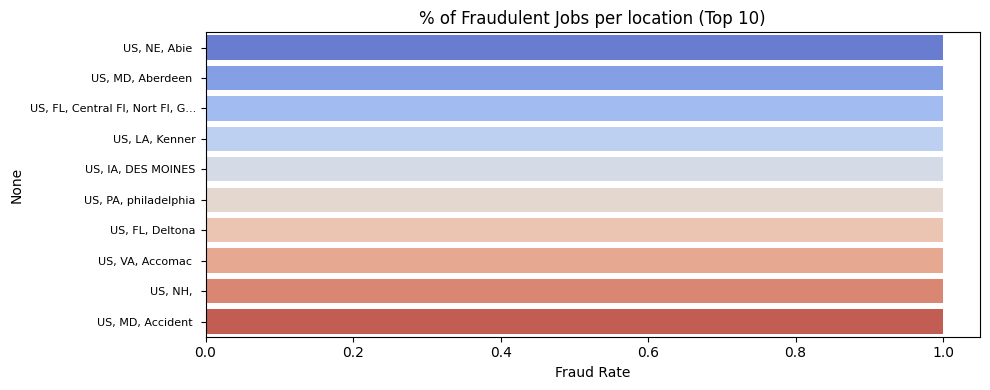

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


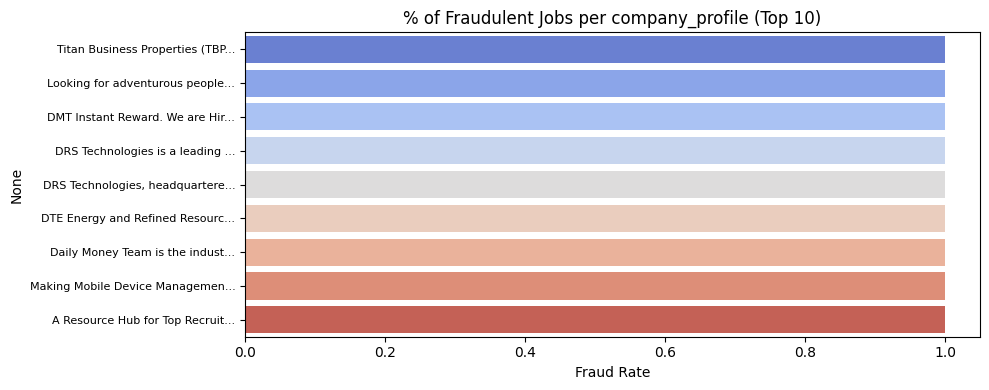

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


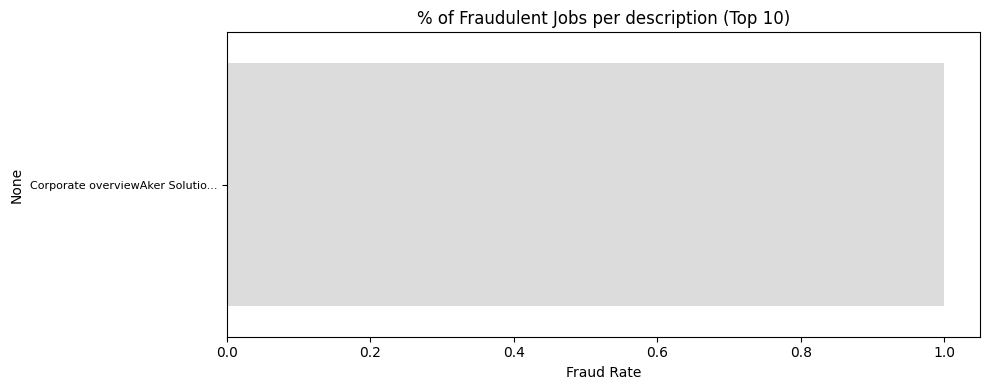

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')
<ipython-input-56-3187643863>:14: UserWarning: Glyph 61623 (\uf0b7) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 61623 (\uf0b7) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


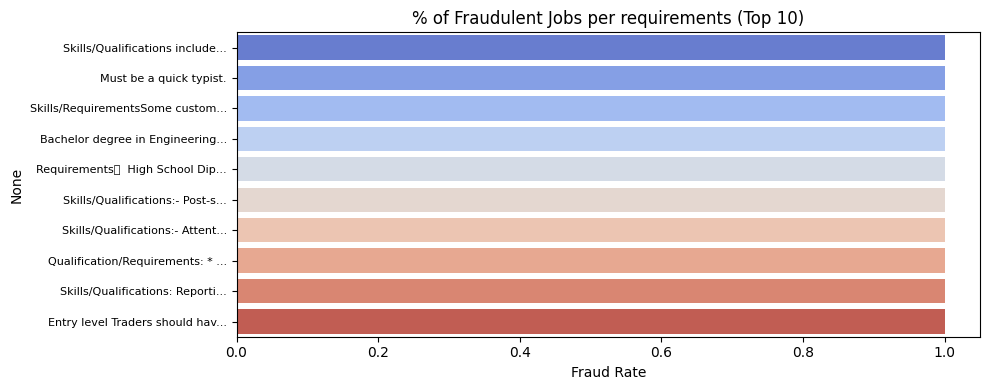

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


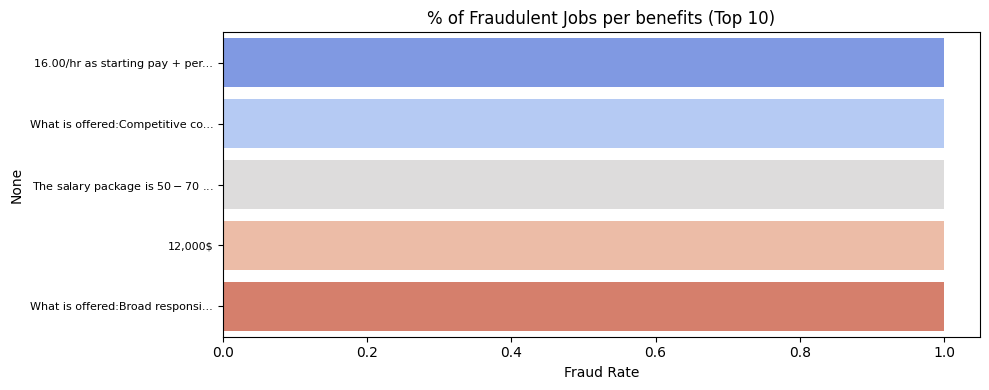

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


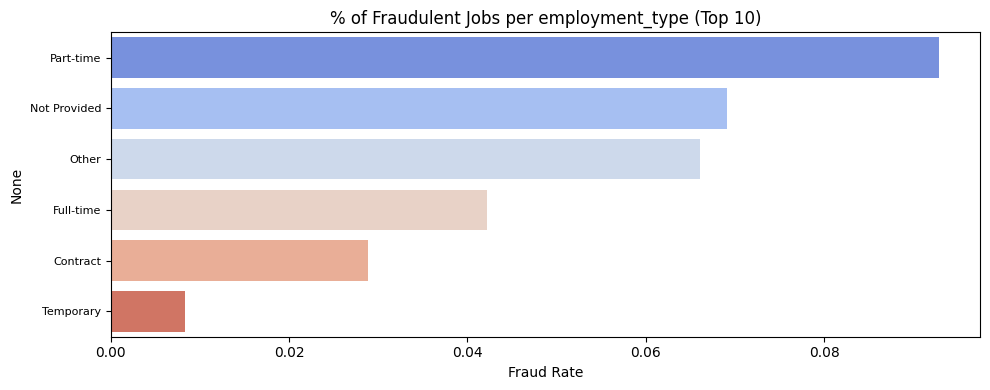

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


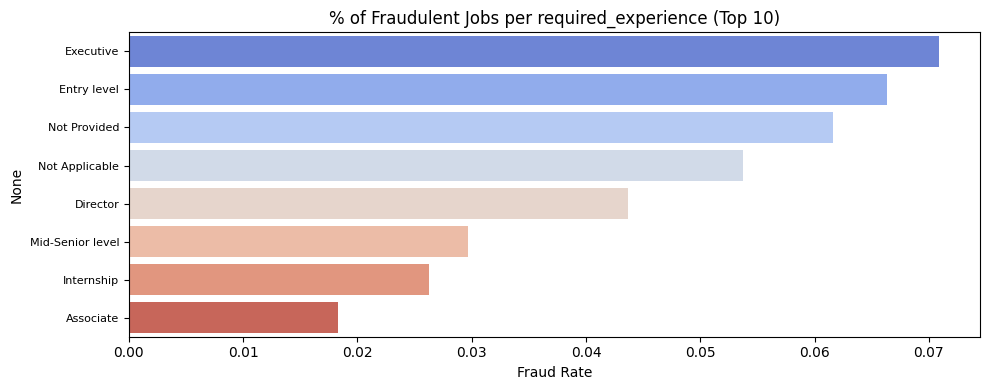

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


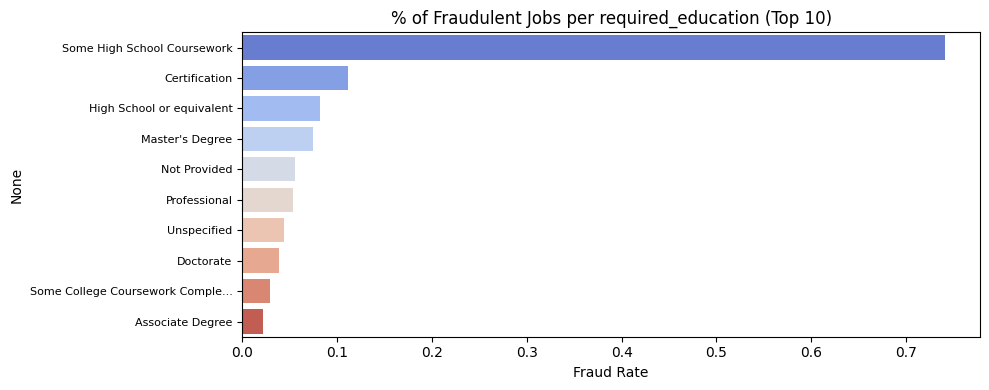

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


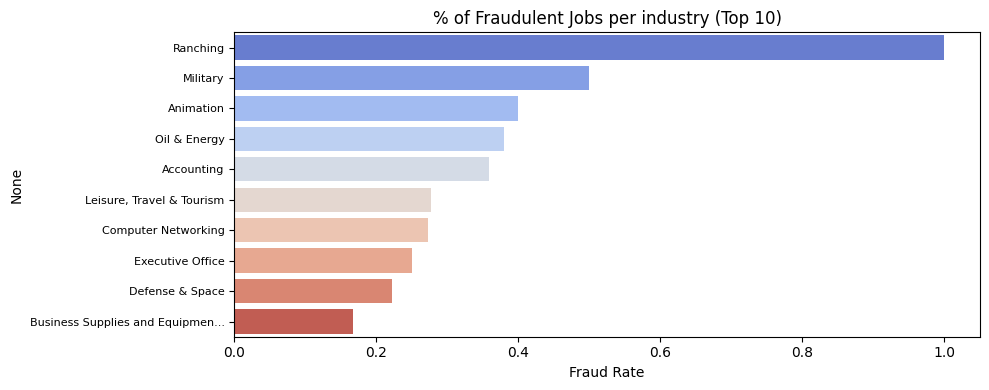

<ipython-input-56-3187643863>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')


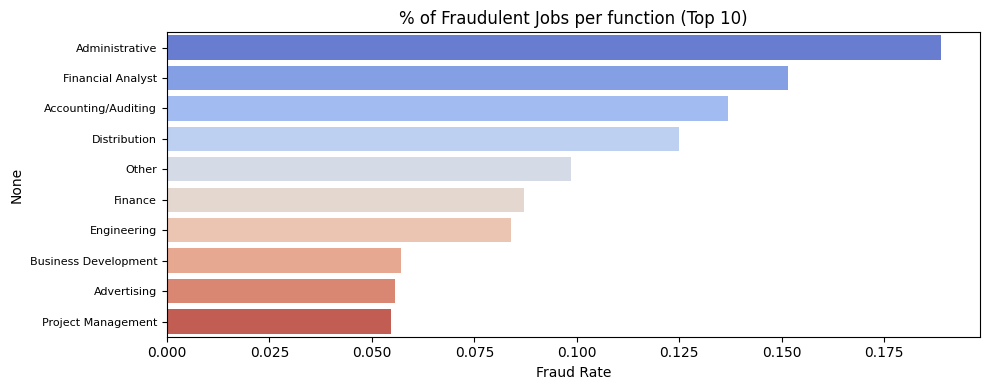

In [56]:
cat_cols = dataset.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    fraud_dist = dataset.groupby(col)['fraudulent'].mean().sort_values(ascending=False)[:10]

    # Truncate long labels
    fraud_dist.index = [str(x)[:30] + '...' if len(str(x)) > 30 else str(x) for x in fraud_dist.index]

    plt.figure(figsize=(10, 4))
    sns.barplot(x=fraud_dist.values, y=fraud_dist.index, palette='coolwarm')
    plt.title(f"% of Fraudulent Jobs per {col} (Top 10)")
    plt.xlabel("Fraud Rate")
    plt.xticks(rotation=0)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

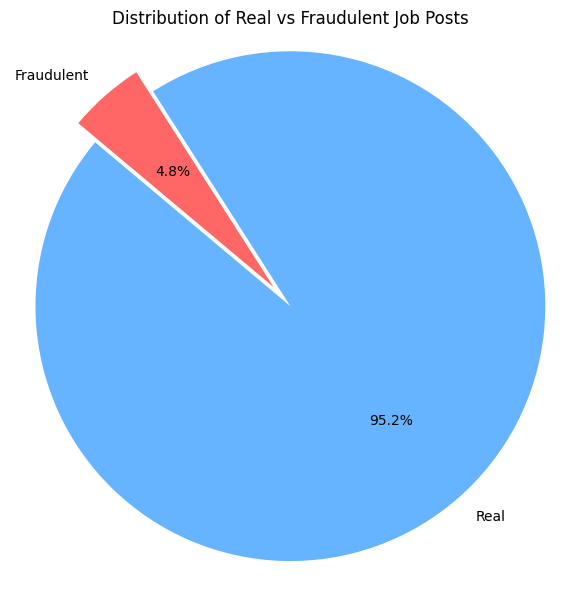

In [57]:
fraud_counts = dataset['fraudulent'].value_counts()
labels = ['Real', 'Fraudulent']
colors = ['#66b3ff', '#ff6666']  # Blue for real, red for fraud

plt.figure(figsize=(6,6))
plt.pie(fraud_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140, explode=[0, 0.1])
plt.title('Distribution of Real vs Fraudulent Job Posts')
plt.axis('equal')
plt.tight_layout()
plt.show()

{'Not Provided': np.int64(7049), 'Mid-Senior level': np.int64(3809), 'Entry level': np.int64(2697), 'Associate': np.int64(2297), 'Not Applicable': np.int64(1116), 'Director': np.int64(389), 'Internship': np.int64(381), 'Executive': np.int64(141)}


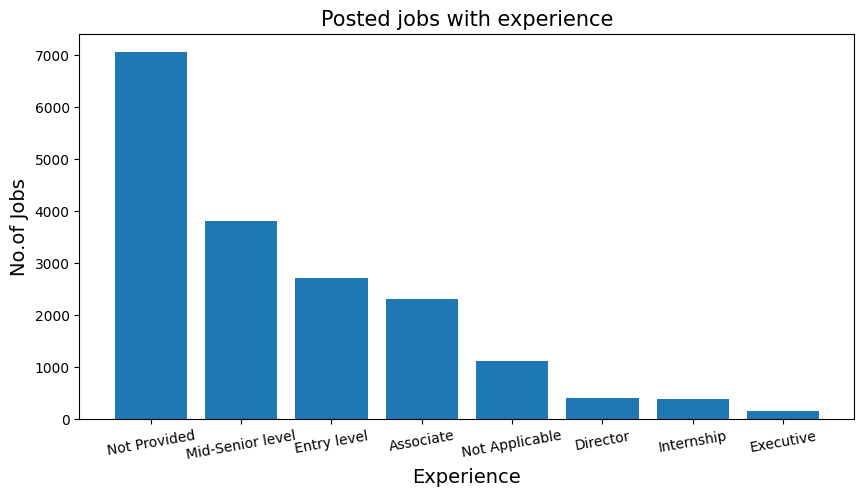

In [58]:
#experience required in the posted jobs
exp = dict(dataset.required_experience.value_counts())
print(exp)
plt.figure(figsize =(10,5))
#sns.set_theme(style = "whitegrid")
plt.bar(exp.keys(),exp.values())
plt.title("Posted jobs with experience",size = 15)
plt.xlabel("Experience", size = 14)
plt.ylabel("No.of Jobs",size = 14)
plt.xticks(rotation = 10)
plt.show()

Top 10 countries where jobs are posted
{'US': np.int64(10656), 'GB': np.int64(2384), 'GR': np.int64(940), 'CA': np.int64(457), 'DE': np.int64(383), 'Not Provided': np.int64(346), 'NZ': np.int64(333), 'IN': np.int64(276), 'AU': np.int64(214), 'PH': np.int64(132)}


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'US'),
  Text(1, 0, 'GB'),
  Text(2, 0, 'GR'),
  Text(3, 0, 'CA'),
  Text(4, 0, 'DE'),
  Text(5, 0, 'Not Provided'),
  Text(6, 0, 'NZ'),
  Text(7, 0, 'IN'),
  Text(8, 0, 'AU'),
  Text(9, 0, 'PH')])

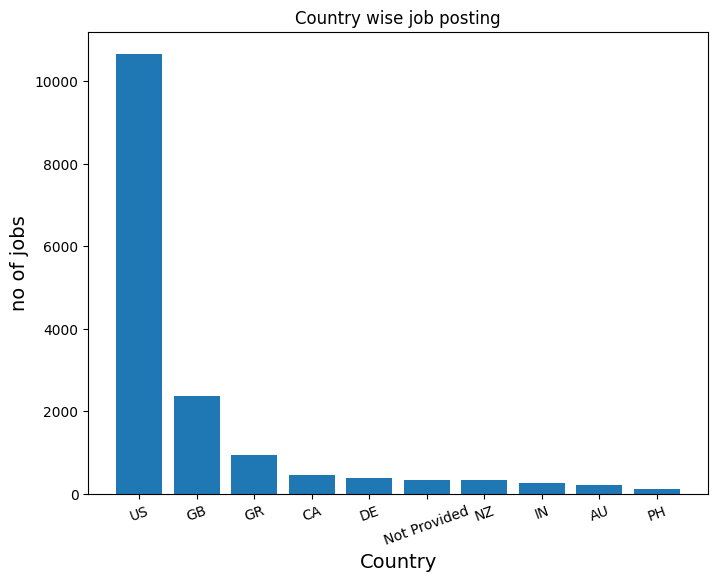

In [59]:
#countries where jobs are posted
def split(location):
    l = location.split(",")
    return l[0]
dataset['country'] = dataset.location.apply(split)

print("Top 10 countries where jobs are posted")
cntry = dict(dataset.country.value_counts()[:10])

print(cntry)
plt.figure(figsize = (8,6))
plt.title("Country wise job posting")
plt.bar(cntry.keys(),cntry.values())
plt.ylabel("no of jobs", size = 14)
plt.xlabel("Country", size = 14)
plt.xticks(rotation = 20)

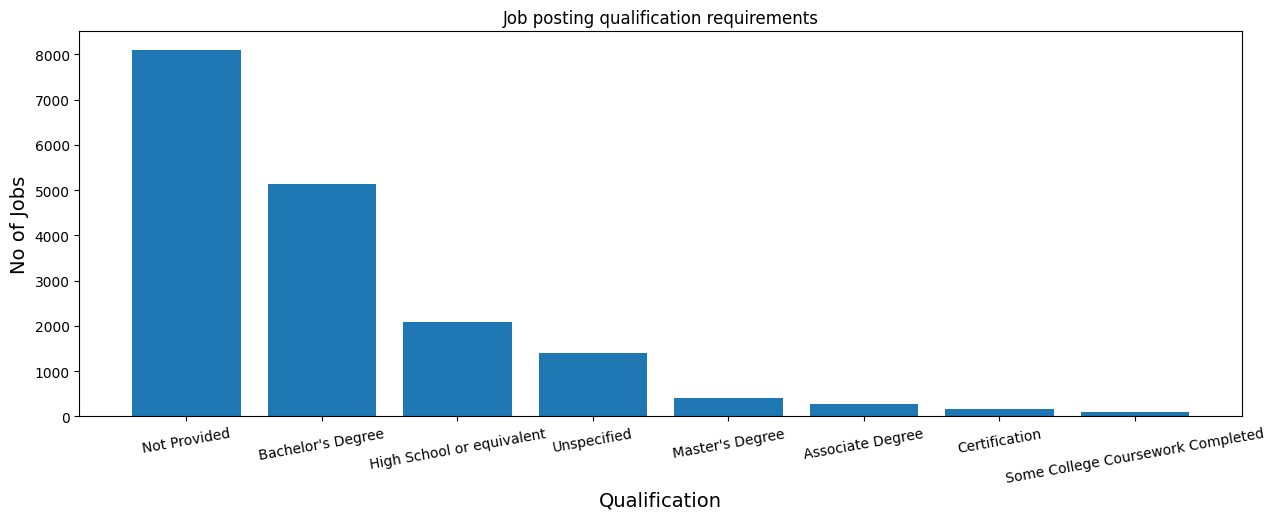

In [60]:
#education requirement for jobs
edu = dict(dataset.required_education.value_counts()[:8])

plt.figure(figsize = (15,5))
plt.title("Job posting qualification requirements")
plt.bar(edu.keys(),edu.values())
plt.ylabel("No of Jobs", size=14)
plt.xlabel("Qualification", size=14)
plt.xticks(rotation = 10)
plt.show()

In [61]:
#non fraudulent job titles
print(dataset[dataset.fraudulent == 0].title.value_counts()[:10])

title
English Teacher Abroad                                311
Customer Service Associate                            146
Graduates: English Teacher Abroad (Conversational)    144
English Teacher Abroad                                 95
Software Engineer                                      86
English Teacher Abroad (Conversational)                83
Customer Service Associate - Part Time                 76
Account Manager                                        73
Web Developer                                          66
Project Manager                                        62
Name: count, dtype: int64


In [62]:
#fraudulent job titles
print(dataset[dataset.fraudulent == 1].title.value_counts()[:10])

title
Data Entry Admin/Clerical Positions - Work From Home                    21
Cruise Staff Wanted *URGENT*                                            21
Home Based Payroll Typist/Data Entry Clerks Positions Available         21
Customer Service Representative                                         17
Administrative Assistant                                                16
Home Based Payroll Data Entry Clerk Position - Earn $100-$200 Daily     12
Payroll Data Coordinator Positions - Earn $100-$200 Daily               10
Account Sales Managers $80-$130,000/yr                                  10
Payroll Clerk                                                           10
Network Marketing                                                       10
Name: count, dtype: int64


In [63]:
dataset['text'] = dataset['title']+' '+dataset['company_profile']+' '+dataset['description']+' '+dataset['requirements']+' '+dataset['benefits']+' '+dataset['employment_type']+' '+dataset['required_experience']+' '+dataset['required_education']+' '+dataset['industry']+' '+dataset['function']

In [64]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
print(STOPWORDS)

{'via', 'anyhow', 'mostly', 'take', 'whose', 'these', 'less', 'name', 'that', 'whole', 'do', 'fifteen', 'else', 'many', 'until', 'must', 'will', 'hereby', 'done', 'your', 'they', 'anywhere', 'only', 'whither', 'ten', 'eight', 'whereby', 'a', 'keep', 'all', 'whence', '‘re', 'first', 'off', 'had', 'their', 'side', '‘d', 'itself', 'hence', 'something', 'two', 'made', "'d", 'before', 'was', 'towards', 'into', 'please', 'indeed', 'too', 'between', 'amongst', 'latterly', 'nobody', 'twenty', 'not', 'several', 'least', 'ca', 'whom', 'further', 'beforehand', 'perhaps', 'under', 'never', 'as', 'because', 'regarding', 'three', 'twelve', '’re', 'someone', 'therein', 'just', 'sometime', 'yet', 'what', 'alone', 'put', 'from', 'noone', 'always', 'are', 'those', 'enough', 'me', 'beside', 'himself', 'much', 'seeming', 'yourselves', 'either', 'everyone', 'also', 'she', 'our', "'ve", 'amount', 'my', 'afterwards', 'in', 'down', 'have', 'whoever', 'former', 'hers', 'he', '’s', 'beyond', 'about', 'top', 'he

In [65]:
fraud_jobs = dataset[dataset.fraudulent == 1].text
real_jobs = dataset[dataset.fraudulent == 0].text

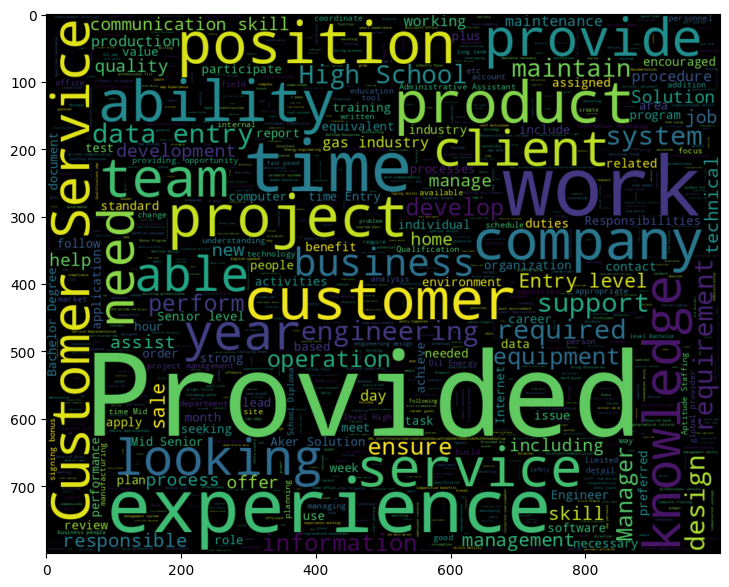

In [66]:
#word cloud of fraudulent jobs

plt.figure(figsize = (10,7))
wc = WordCloud(min_font_size = 3, max_words = 3000 ,width= 1000,height = 800,
               stopwords = STOPWORDS).generate(str(" ".join(fraud_jobs)))
plt.imshow(wc,interpolation = 'bilinear')

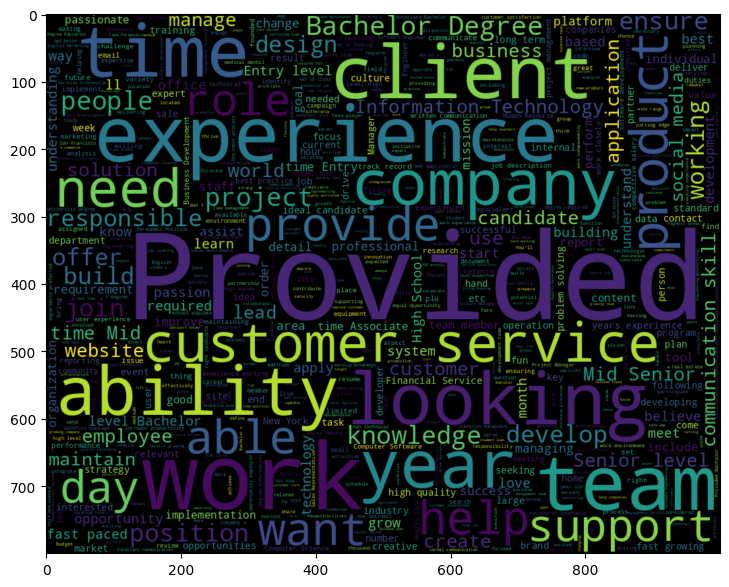

In [67]:
#word cloud of real jobs

plt.figure(figsize = (10,7))
wc = WordCloud(min_font_size = 3, max_words = 3000 ,width= 1000,height = 800, stopwords = STOPWORDS).generate(str(" ".join(real_jobs)))
plt.imshow(wc,interpolation = 'bilinear')

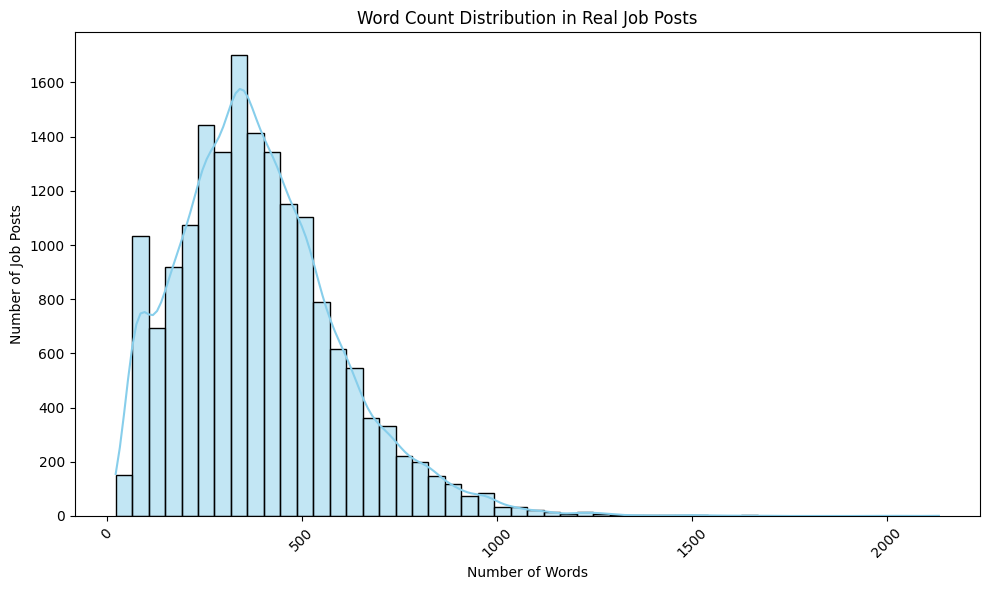

In [68]:
real_word_counts = real_jobs.apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(real_word_counts, bins=50, kde=True, color='skyblue')
plt.title('Word Count Distribution in Real Job Posts')
plt.xlabel('Number of Words')
plt.ylabel('Number of Job Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

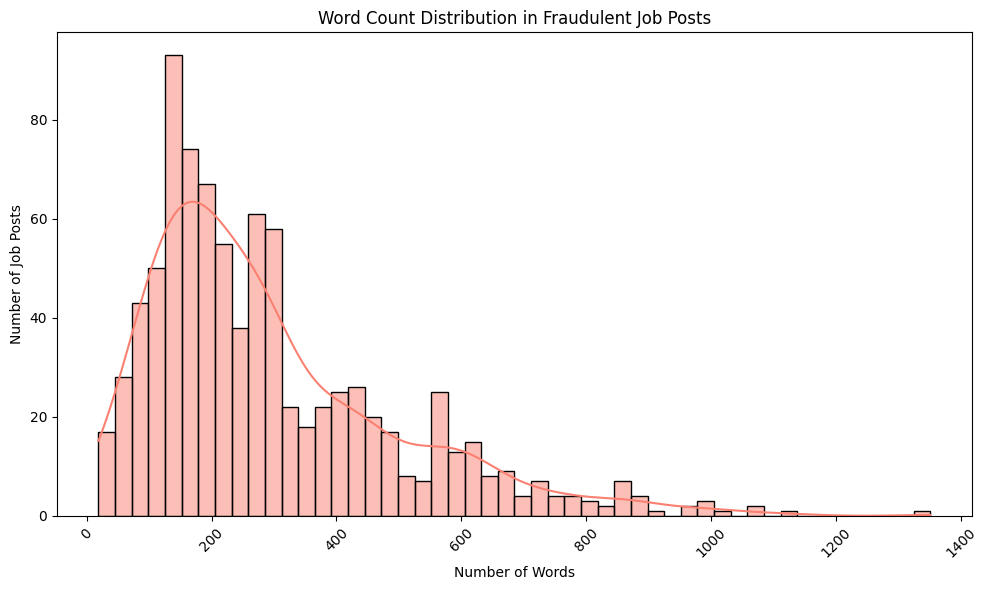

In [69]:
fraud_word_counts = fraud_jobs.apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(fraud_word_counts, bins=50, kde=True, color='salmon')
plt.title('Word Count Distribution in Fraudulent Job Posts')
plt.xlabel('Number of Words')
plt.ylabel('Number of Job Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Pre Processing

In [70]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatize(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_punct and not token.is_space])

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\S+@\S+', '', text) # Remove emails
    text = re.sub(r'http\S+|www\S+|ftp\S+', '', text) # Remove URLs
    text = BeautifulSoup(text, 'lxml').get_text() # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove punctuation and digits
    text = " ".join(text.split()) # Remove extra spaces
    text = " ".join([word for word in text.split() if word not in STOP_WORDS]) # Remove stop words
    text = lemmatize(text)
    return text

In [71]:
print(dataset['text'][0])

Marketing Intern We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and cur

In [72]:
tqdm.pandas()

In [73]:
dataset['text'] = dataset['text'].progress_apply(clean_text)

  0%|          | 0/17879 [00:00<?, ?it/s]

In [74]:
print(dataset['text'][0])

marketing intern food ve create groundbreake award win cooking site support connect celebrate home cook need place editorial business engineering team focus technology find new well way connect people specific food interest offer superb highly curate information food cooking attract talented home cook contributor country publish know professional like mario batali gwyneth paltrow danny meyer partnership food market random house food name good food website james beard foundation iacp feature new york times npr pando daily techcrunch today locate chelsea new york city food fast grow james beard award win online food community crowd source curate recipe hub currently interview time unpaid intern work small team editor executive developer new york city headquarters reproduce repackage exist food content number partner site huffington post yahoo buzzfeed content management systemsresearche blog website provision food affiliate programassiste day day affiliate program support screening affil

### Modeling

In [75]:
!wget --no-check-certificate https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
!unzip glove.6B.zip

--2025-06-12 20:36:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.02MB/s    in 2m 39s  

2025-06-12 20:38:39 (5.16 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [76]:
# Load GloVe 200D
embedding_index = {}
with open('glove.6B.200d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = vector
print(f"Loaded {len(embedding_index)} word vectors.")

Loaded 400000 word vectors.


In [77]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

def sentence_to_vector(text):
    words = word_tokenize(text)
    vectors = [embedding_index[word] for word in words if word in embedding_index]

    if len(vectors) == 0:
        return np.zeros(100)
    return np.mean(vectors, axis=0)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [78]:
from imblearn.over_sampling import SMOTE

# Convert all sentences to vectors
X = np.vstack(dataset['text'].progress_apply(sentence_to_vector))
y = dataset['fraudulent'].values

# Apply SMOTE to balance the classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

  0%|          | 0/17879 [00:00<?, ?it/s]

In [79]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_resampled.shape[1],)))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', AUC(name='auc')]
)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [81]:
history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test), verbose=1,
                    callbacks=[early_stop])

Epoch 1/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7283 - auc: 0.7998 - loss: 0.5579 - val_accuracy: 0.8448 - val_auc: 0.9227 - val_loss: 0.3801
Epoch 2/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8559 - auc: 0.9257 - loss: 0.3626 - val_accuracy: 0.8876 - val_auc: 0.9519 - val_loss: 0.2974
Epoch 3/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8857 - auc: 0.9497 - loss: 0.2973 - val_accuracy: 0.9027 - val_auc: 0.9624 - val_loss: 0.2586
Epoch 4/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9019 - auc: 0.9613 - loss: 0.2605 - val_accuracy: 0.9099 - val_auc: 0.9699 - val_loss: 0.2352
Epoch 5/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9119 - auc: 0.9682 - loss: 0.2352 - val_accuracy: 0.9254 - val_auc: 0.9741 - val_loss: 0.2145
Epoch 6/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9223 - auc: 0.9744 - loss: 0.2120 - val_accuracy: 0.9251 - val_auc: 0.9775 - val_loss: 0.2019
Epoch 7/30
426/426 ━━━━━━━━━━━━━━━━━━━━ 

In [82]:
loss, accuracy, auc_score = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test AUC Score: {auc_score:.4f}")

Test Loss: 0.0546
Test Accuracy: 0.9843
Test AUC Score: 0.9972


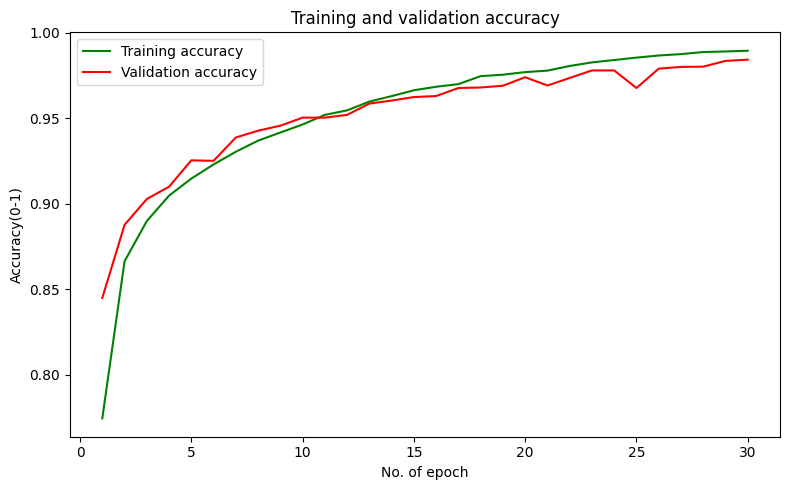

In [83]:
epochs = range(1, len(history.history['accuracy']) + 1)
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, 'g-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.xlabel('No. of epoch')
plt.ylabel('Accuracy(0-1)')
plt.legend()

plt.tight_layout()
plt.show()

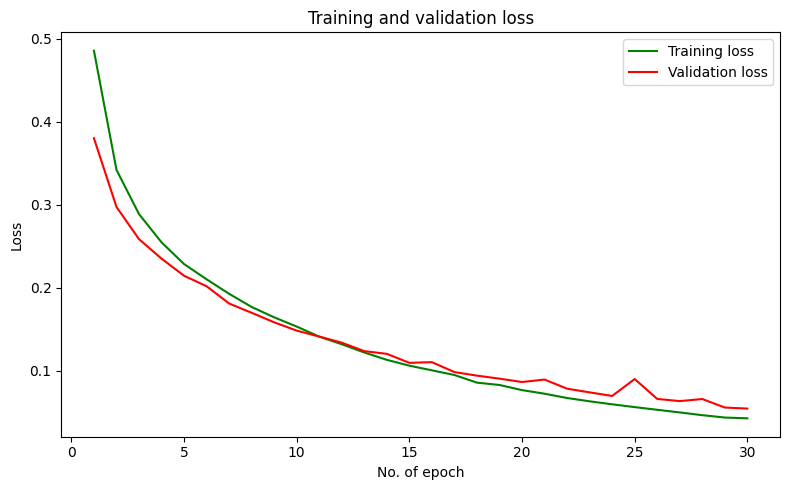

In [84]:
epochs = range(1, len(history.history['loss']) + 1)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_loss, 'g-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('No. of epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

 # A Comparative Study on Fake Job Post Prediction Using Different Data mining Techniques

In [85]:
df = pd.read_csv(r"fake job posting(Sheet1).csv")
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [86]:
df = df[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education',
         'fraudulent']]
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent
0,0,1,0,Other,Internship,NaN,0
1,0,1,0,Full-time,Not Applicable,NaN,0
2,0,1,0,NaN,NaN,NaN,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0


In [87]:
fill_cols = ['employment_type', 'required_experience', 'required_education']
df[fill_cols] = df[fill_cols].fillna("Not Provided")

<ipython-input-87-3734232723>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[fill_cols] = df[fill_cols].fillna("Not Provided")


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   telecommuting        17880 non-null  int64 
 1   has_company_logo     17880 non-null  int64 
 2   has_questions        17880 non-null  int64 
 3   employment_type      17880 non-null  object
 4   required_experience  17880 non-null  object
 5   required_education   17880 non-null  object
 6   fraudulent           17880 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 977.9+ KB


In [89]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
for col in cat_cols:
    print('--------------------')
    print(df[col].value_counts())

--------------------
employment_type
Full-time       11620
Not Provided     3471
Contract         1524
Part-time         797
Temporary         241
Other             227
Name: count, dtype: int64
--------------------
required_experience
Not Provided        7050
Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: count, dtype: int64
--------------------
required_education
Not Provided                         8105
Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                           

In [90]:
employment_type_mapping = {
    'Not Provided': 0,
    'Full-time': 1,
    'Part-time': 2,
    'Other': 3,
    'Contract': 4,
    'Temporary': 5
}

df['employment_type_encoded'] = df['employment_type'].map(employment_type_mapping)

<ipython-input-90-4217323848>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['employment_type_encoded'] = df['employment_type'].map(employment_type_mapping)


In [91]:
experience_mapping = {
    'Not Provided': 0,
    'Not Applicable': 1,
    'Internship': 2,
    'Entry level': 3,
    'Associate': 4,
    'Mid-Senior level': 5,
    'Director': 6,
    'Executive': 7
}

df['required_experience_encoded'] = df['required_experience'].map(experience_mapping)

<ipython-input-91-1542307627>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['required_experience_encoded'] = df['required_experience'].map(experience_mapping)


In [92]:
education_mapping = {
    'Not Provided': 0,
    'Unspecified': 1,
    'Some High School Coursework': 2,
    'Vocational - HS Diploma': 3,
    'High School or equivalent': 4,
    'Some College Coursework Completed': 5,
    'Vocational': 6,
    'Certification': 7,
    'Associate Degree': 8,
    "Bachelor's Degree": 9,
    'Professional': 10,
    "Master's Degree": 11,
    'Vocational - Degree': 12,
    'Doctorate': 13
}

df['required_education_encoded'] = df['required_education'].map(education_mapping)

In [93]:
df.head()

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,employment_type_encoded,required_experience_encoded,required_education_encoded
0,0,1,0,Other,Internship,Not Provided,0,3,2,0
1,0,1,0,Full-time,Not Applicable,Not Provided,0,1,1,0
2,0,1,0,Not Provided,Not Provided,Not Provided,0,0,0,0
3,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,0,1,5,9
4,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,0,1,5,9


In [94]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
for col in num_cols:
  print('-----------------')
  print(df[col].value_counts())

-----------------
telecommuting
0    17113
1      767
Name: count, dtype: int64
-----------------
has_company_logo
1    14220
0     3660
Name: count, dtype: int64
-----------------
has_questions
0    9088
1    8792
Name: count, dtype: int64
-----------------
fraudulent
0    17014
1      866
Name: count, dtype: int64
-----------------
employment_type_encoded
1    11620
0     3471
4     1524
2      797
5      241
3      227
Name: count, dtype: int64
-----------------
required_experience_encoded
0    7050
5    3809
3    2697
4    2297
1    1116
6     389
2     381
7     141
Name: count, dtype: int64
-----------------
required_education_encoded
0     8105
9     5145
4     2080
1     1397
11     416
8      274
7      170
5      102
10      74
6       49
2       27
13      26
3        9
12       6
Name: count, dtype: int64


In [95]:
df = df[['telecommuting', 'has_company_logo', 'has_questions', 'employment_type_encoded', 'required_experience_encoded',
          'required_education_encoded', 'fraudulent']]
df.head()

,telecommuting,has_company_logo,has_questions,employment_type_encoded,required_experience_encoded,required_education_encoded,fraudulent
0,0,1,0,3,2,0,0
1,0,1,0,1,1,0,0
2,0,1,0,0,0,0,0
3,0,1,0,1,5,9,0
4,0,1,1,1,5,9,0


In [96]:
from sklearn.model_selection import train_test_split

In [97]:
X = df.drop('fraudulent', axis=1)
y = df['fraudulent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [98]:
from sklearn.neighbors import KNeighborsClassifier

error_rates = []
for k in range(1, 41):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    pred_k = knn.predict(X_test)
    error = np.mean(pred_k != y_test)
    error_rates.append(error)

best_k = np.argmin(error_rates) + 1
print(f"Best k: {best_k}, Minimum error: {error_rates[best_k-1]:.4f}")

Best k: 28, Minimum error: 0.0475


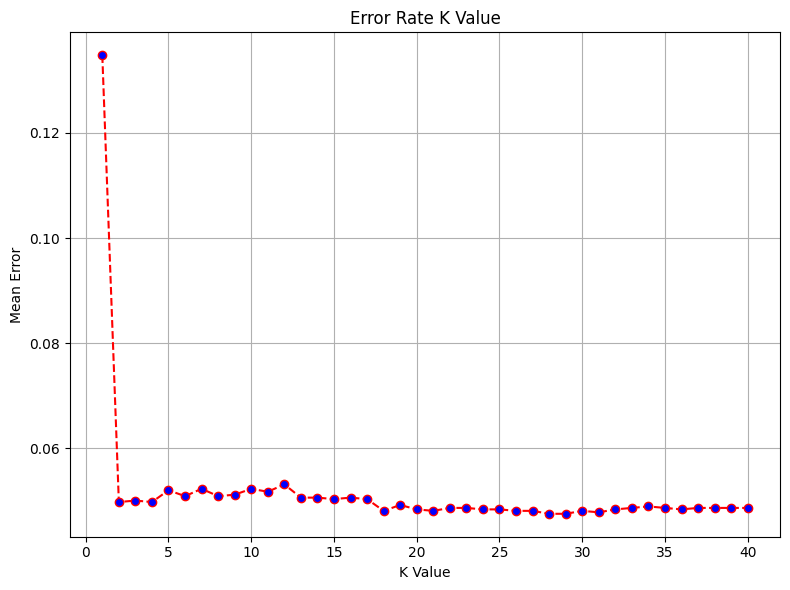

In [99]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 41), error_rates, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=6)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')
plt.grid(True)
plt.tight_layout()

plt.show()

In [100]:
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train, y_train)
y_pred_knn = knn_final.predict(X_test)

In [101]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [102]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', gamma=0.001)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

In [103]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [104]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

In [105]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics(model_name, y_true, y_pred):
    print(f"\n{model_name} Performance:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='weighted'):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred, average='weighted'):.4f}")

print_metrics("K-Nearest Neighbors (k=13)", y_test, y_pred_knn)
print_metrics("Random Forest", y_test, y_pred_rf)
print_metrics("SVM (RBF Kernel, gamma=0.001)", y_test, y_pred_svm)
print_metrics("Decision Tree", y_test, y_pred_dt)
print_metrics("Naive Bayes", y_test, y_pred_nb)
print_metrics("Multilayer Perceptron (MLP)", y_test, y_pred_mlp)


K-Nearest Neighbors (k=13) Performance:
Accuracy : 0.9525
Precision: 0.9450
Recall   : 0.9525
F1 Score : 0.9338

Random Forest Performance:
Accuracy : 0.9505
Precision: 0.9342
Recall   : 0.9505
F1 Score : 0.9333

SVM (RBF Kernel, gamma=0.001) Performance:
Accuracy : 0.9494
Precision: 0.9013
Recall   : 0.9494
F1 Score : 0.9247

Decision Tree Performance:
Accuracy : 0.9494
Precision: 0.9310
Recall   : 0.9494
F1 Score : 0.9330

Naive Bayes Performance:
Accuracy : 0.9231
Precision: 0.9087
Recall   : 0.9231
F1 Score : 0.9156

Multilayer Perceptron (MLP) Performance:
Accuracy : 0.9511
Precision: 0.9535
Recall   : 0.9511
F1 Score : 0.9288


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [107]:
results = []

def collect_metrics(model_name, y_true, y_pred):
    results.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    })

collect_metrics("K-Nearest Neighbors", y_test, y_pred_knn)
collect_metrics("Random Forest", y_test, y_pred_rf)
collect_metrics("SVM", y_test, y_pred_svm)
collect_metrics("Decision Tree", y_test, y_pred_dt)
collect_metrics("Naive Bayes", y_test, y_pred_nb)
collect_metrics("Multilayer Perceptron (MLP)", y_test, y_pred_mlp)

results_df = pd.DataFrame(results)
results_df

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Accuracy,Precision,Recall,F1 Score
0,K-Nearest Neighbors,0.952461,0.945038,0.952461,0.933761
1,Random Forest,0.950503,0.934158,0.950503,0.933331
2,SVM,0.949385,0.901331,0.949385,0.924734
3,Decision Tree,0.949385,0.930978,0.949385,0.933003
4,Naive Bayes,0.923098,0.908717,0.923098,0.915648
5,Multilayer Perceptron (MLP),0.951063,0.953462,0.951063,0.928779


In [108]:
from imblearn.over_sampling import SMOTE

X_array = X.values
y_array = y.values

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []
precision_scores = []
recall_scores = []
conf_matrices = []

fold_number = 1

for train_index, test_index in kf.split(X_array,y_array):
    X_train_fold, X_test_fold = X_array[train_index], X_array[test_index]
    y_train_fold, y_test_fold = y_array[train_index], y_array[test_index]

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)

    model = Sequential()
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

    model.fit(X_train_resampled, y_train_resampled, epochs=20, batch_size=32, verbose=0)

    y_pred_prob = model.predict(X_test_fold).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    acc = accuracy_score(y_test_fold, y_pred)
    prec = precision_score(y_test_fold, y_pred, zero_division=0)
    rec = recall_score(y_test_fold, y_pred, zero_division=0)
    cm = confusion_matrix(y_test_fold, y_pred)

    accuracy_scores.append(acc)
    precision_scores.append(prec)
    recall_scores.append(rec)
    conf_matrices.append(cm)

    print(f"Fold {fold_number} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}")
    fold_number += 1

print("\nAverage Accuracy:", np.mean(accuracy_scores))
print("Average Precision:", np.mean(precision_scores))
print("Average Recall:", np.mean(recall_scores))

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Fold 1 - Accuracy: 0.7668, Precision: 0.1530, Recall: 0.8488
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 2 - Accuracy: 0.7925, Precision: 0.1550, Recall: 0.7442
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 3 - Accuracy: 0.7763, Precision: 0.1527, Recall: 0.8023
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 4 - Accuracy: 0.7573, Precision: 0.1506, Recall: 0.8721
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 5 - Accuracy: 0.7740, Precision: 0.1591, Recall: 0.8506
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 6 - Accuracy: 0.7701, Precision: 0.1524, Recall: 0.8161
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 7 - Accuracy: 0.7740, Precision: 0.1620, Recall: 0.8736
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 8 - Accuracy: 0.7713, Precision: 0.1589, Recall: 0.8621
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 9 - Accuracy: 0.7685, Precision: 0.1572, Recall: 0.8621
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Fold 10 - Accuracy: 0.7875, Precision: 0.1601, Recall: 0.7931

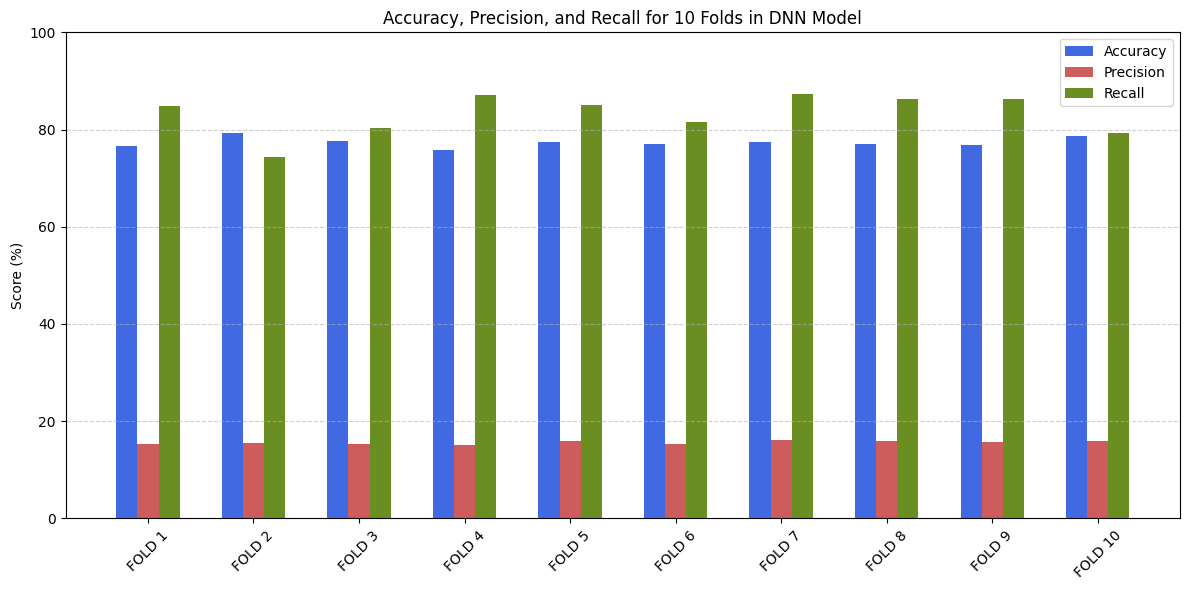

In [109]:
folds = np.arange(1, 11)
plt.figure(figsize=(12, 6))
plt.bar(folds - 0.2, np.array(accuracy_scores) * 100, width=0.2, label='Accuracy', color='royalblue')
plt.bar(folds, np.array(precision_scores) * 100, width=0.2, label='Precision', color='indianred')
plt.bar(folds + 0.2, np.array(recall_scores) * 100, width=0.2, label='Recall', color='olivedrab')

plt.xticks(folds, [f"FOLD {i}" for i in folds], rotation=45)
plt.ylim(0, 100)
plt.ylabel("Score (%)")
plt.title("Accuracy, Precision, and Recall for 10 Folds in DNN Model")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

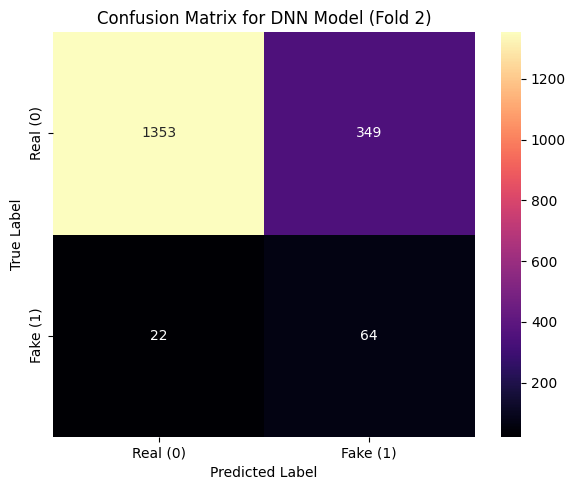

In [110]:
cm_fold_2 = conf_matrices[1]

plt.figure(figsize=(6, 5))
sns.heatmap(cm_fold_2, annot=True, fmt='d', cmap='magma',
            xticklabels=['Real (0)', 'Fake (1)'], yticklabels=['Real (0)', 'Fake (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for DNN Model (Fold 2)')
plt.tight_layout()
plt.show()